#Simplex


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from math import comb


## Dimension n ##

def NelderMead(f, x, maxit=1500, rho=1, gamma=2, alpha=1/2, sigma=1/2, tolerance=5e-2):

    n1,n2 = x.shape
    simplex = [x[:,i] for i in range(n2)]
    simplex = np.array(simplex)
    nit = 0
    all_simplex = [simplex.copy()]

    while nit < maxit:
        simplex_sorted = sorted(simplex, key = f, reverse=False)
        all_simplex.append(simplex_sorted)

        m = np.mean(simplex_sorted[0:-1], axis=0)

        r = m + rho* (m- simplex_sorted[-1])  #reflection point

        if f(simplex_sorted[0]) <= f(r) < f(simplex_sorted[-2]):
            simplex_sorted[-1] = r


        elif f(r) < f(simplex_sorted[0]):
            e = m + gamma* (r - m) #extension point
            if f(e) < f(r):
                simplex_sorted[-1] = e
            else:
                simplex_sorted[-1] = r


        elif f(r) < f(simplex_sorted[-1]):
            co = m + alpha* (r - m) #contraction point outside
            if f(co) < f(simplex_sorted[-1]):
                simplex_sorted[-1] = co


        else:
            ci = m + alpha* (simplex_sorted[-1] - m) #contractoion point inside
            if f(ci) < f(simplex_sorted[-1]):
                simplex_sorted[-1] = ci
            else:
                simplex_sorted[1:] = simplex_sorted[0] + sigma* (simplex_sorted[1:] - simplex_sorted[0])

        simplex = simplex_sorted

        if np.linalg.norm(simplex_sorted[-1] - simplex_sorted[0]) < tolerance:
            break

        nit +=1

    best_point = simplex_sorted[0]
    best_value = f(best_point)
    return all_simplex, best_point, best_value, nit


###### Problem

# domain length
l = 1
# number of elements
n_el = 200
# element size
h = l/n_el
# number of nodes
n_no = n_el+1
# nodes coordinates
X = np.linspace(0,1,n_no)
# integration points coordinates
Xg = 0.5*( X[:-1] + X[1:] )
# target temperature
T_star = np.ones(X.shape) + (X/l)**2
# initial design vector that parameterizes heat sources
dim_opt = 3
Var_ini = np.full(dim_opt,0)
# conduction coefficient with possible noise
rng = np.random.default_rng(seed=2024)

def compute_conduction(noise_val):
    noise = rng.random(Xg.shape) * noise_val
    K = np.ones(Xg.shape) +  0.4*np.sin(4*np.pi*Xg/l) +  0.3*np.sin(12*np.pi*Xg/l) + noise
    return K

# without noise
K_ref = compute_conduction(0)

def bernstein_poly(i, n, x):
    return comb(n, i) * (x ** i) * ((1 - x) ** (n - i))

def compute_source(Var_opt):

    S = np.ones(Xg.shape)
    for i in range(len(Var_opt)):
        #S += Var_opt[i] * np.sin((i+1) * np.pi * Xg)
        #S += Var_opt[i] * bernstein_poly(i, len(Var_opt) - 1, Xg)
        S += Var_opt[i] * Xg**i
    return S

def compute_matrix(K):
    # Finite-Element matrix initialisation
    M = np.zeros((n_no,n_no))

    # Boundary conditions
    M[0][0] = 1
    M[n_no-1][n_no-1] = 1

    # Internal coeff
    for i in range(1,n_no-1):
        M[i][i] = (K[i-1]+K[i])/h
        M[i][i-1] = -K[i-1]/h
        M[i][i+1] = -K[i]/h
    return M

def compute_rhs(S):
    # Finite-Element right-hand side initialisation
    Rhs = np.zeros((n_no,1))

    # Boundary conditions
    Rhs[0] = 1
    Rhs[n_no-1] = 2

    # internal coeff
    for i in range(1,n_no-1):
        Rhs[i] = (S[i-1]+S[i])*h/2
    return Rhs

def simulator(noise,Var):
    # conduction
    K = compute_conduction(noise)

    # matrix
    M = compute_matrix(K)

    # compute heat source
    Src = compute_source(Var)

    # right-hand side
    Rhs = compute_rhs(Src)

    # Finite-element solution
    T = np.matmul(np.linalg.inv(M),Rhs).reshape((n_no))
    return T





# **nash dim 4**

In [ ]:

T_star = np.ones(X.shape) + (X/l)**2
T_star2 = np.where((X >= 0) & (X <= 0.5), 1, np.where((X > 0.5) & (X <= 1), 2, None))

def J1(S) :
    T = simulator(0,S)
    r = 0
    for i in range(len(T)):
        r += 0.5*((T[i]-T_star[i])**2)*h
    return r

def J2(S) :
    T = simulator(0,S)
    r = 0
    for i in range(len(T)):
        r += 0.5*((T[i]-T_star2[i])**2)*h
    return r


def Opt1(Var, simplex, ite_max, tol):

  for i in range(ite_max):

    Var_opt = Var.copy()
    Var_opt[:dim_opt//2] = NelderMead(J1, simplex)[1][:dim_opt//2]
    if J1(Var_opt) < tol:
      break
    simplex = np.array(NelderMead(J1, simplex)[0][-1]).T


  return Var_opt, simplex

def Opt2(Var, simplex, ite_max, tol):

  for i in range(ite_max):
    Var_opt = Var.copy()
    Var_opt[dim_opt//2:] = NelderMead(J2, simplex)[1][dim_opt//2:]
    if J2(Var_opt) < tol:
      break
    simplex = np.array(NelderMead(J2, simplex)[0][-1]).T

  return Var_opt, simplex

def Nash_NelderMead(Var, simplex, ite_max, tol):

    iter_count = 0
    Var_opt = Var.copy()

    while iter_count <= ite_max:

        Var_opt, simplex = Opt1(Var_opt, simplex, ite_max, tol)
        Var_opt, simplex = Opt2(Var_opt, simplex, ite_max, tol)

        print(f'iteration:{iter_count}')
        print(Var_opt)
        if np.linalg.norm(simulator(0, Var) - simulator(0, Var_opt)) < tol:
            print("Nash equivalence")
            break
        Var = Var_opt
        iter_count +=1

    return simulator(0, Var_opt)

dim_opt = 4
Var_ini = np.full(dim_opt,0)
simplex = np.column_stack((np.zeros(dim_opt), -3 * np.eye(dim_opt)))



max_iter2 = 6
max_iter3 = 7
max_iter4 = 8
max_iter5 = 9

max_iter7 = 4


T_ini = simulator(0, Var_ini)
tol = 5e-2

max_iter0 = 100
T_final1 = Nash_NelderMead(Var_ini, simplex, max_iter0, tol)
max_iter1 = 150
T_final2 = Nash_NelderMead(Var_ini, simplex, max_iter1, tol)
max_iter6 = 200
T_final7 = Nash_NelderMead(Var_ini, simplex, max_iter6, tol)


T_final3 = Nash_NelderMead(Var_ini, simplex, max_iter2, tol)
T_final4 = Nash_NelderMead(Var_ini, simplex, max_iter3, tol)
T_final5 = Nash_NelderMead(Var_ini, simplex, max_iter4, tol)
T_final6 = Nash_NelderMead(Var_ini, simplex, max_iter5, tol)

T_final8 = Nash_NelderMead(Var_ini, simplex, max_iter7, tol)

iteration:0
[  0 -17  12   8]
iteration:1
[  0 -17   6   1]
iteration:2
[  0 -17  12   8]
iteration:3
[  0 -17   6   1]
iteration:0
[  0 -17  10  -1]
iteration:1
[  0 -17  11   8]
iteration:2
[  0 -16  12   0]
iteration:3
[-15  20  12   0]
iteration:4
[-15  20  12   0]
Nash equivalence
iteration:0
[  0 -17  12   8]
iteration:1
[  0 -17  11  -2]
iteration:2
[-16  23  11  -2]
iteration:3
[-16  23  11  -2]
Nash equivalence
iteration:0
[  0 -17  12   8]
iteration:1
[  0 -16  24   4]
iteration:2
[  0 -17  24   4]
iteration:3
[  0 -17  24   4]
Nash equivalence
iteration:0
[  0 -17 -32 -32]
iteration:1
[  0 -17 -37 -36]
iteration:2
[-21  77 -36 -36]
iteration:3
[-21  77 -36 -36]
Nash equivalence
iteration:0
[  0 -17  11   7]
iteration:1
[  0 -16  -2   6]
iteration:2
[-17  29  -2   6]
iteration:3
[-17  29  -2   6]
Nash equivalence
iteration:0
[  0 -17  12   9]
iteration:1
[  0 -17  14  -4]
iteration:2
[-16  22  14  -4]
iteration:0
[  0 -17  12   8]
iteration:1
[  0 -17   2  -7]
iteration:2
[-2

implementation

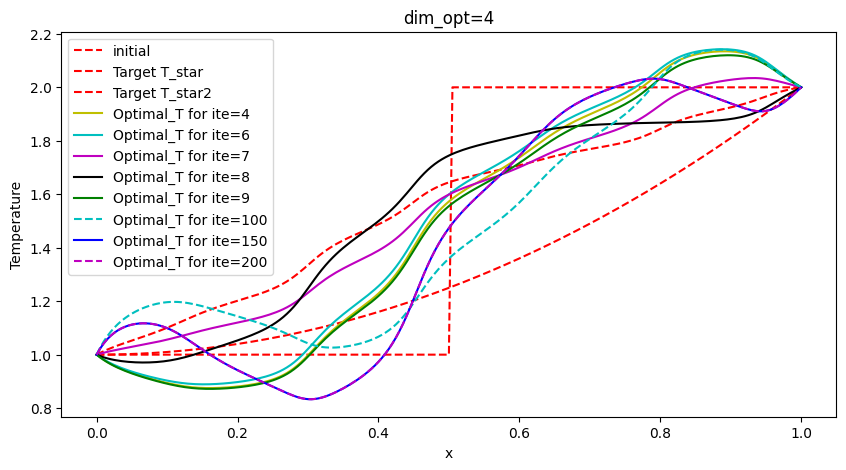

In [ ]:



plt.figure(figsize=(10,5))
plt.plot(X, T_ini, 'r--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'r--', label='Target T_star2')


plt.plot(X, T_final8, 'y', label=f'Optimal_T for ite={max_iter7}')
plt.plot(X, T_final3, 'c', label=f'Optimal_T for ite={max_iter2}')
plt.plot(X, T_final4, 'm', label=f'Optimal_T for ite={max_iter3}')
plt.plot(X, T_final5, 'k', label=f'Optimal_T for ite={max_iter4}')
plt.plot(X, T_final6, 'g', label=f'Optimal_T for ite={max_iter5}')

plt.plot(X, T_final1, 'c--', label=f'Optimal_T for ite={max_iter0}')
plt.plot(X, T_final2, 'b', label=f'Optimal_T for ite={max_iter1}')
plt.plot(X, T_final7, 'm--', label=f'Optimal_T for ite={max_iter6}')

plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

In [ ]:
max_iter1 = 150
max_iter2 = 200
max_iter3 = 300
max_iter4 = 400
max_iter5 = 600

T_f1 = Nash_NelderMead(Var_ini, simplex, max_iter1, tol)
T_f2 = Nash_NelderMead(Var_ini, simplex, max_iter2, tol)
T_f3 = Nash_NelderMead(Var_ini, simplex, max_iter3, tol)
T_f4 = Nash_NelderMead(Var_ini, simplex, max_iter4, tol)
T_f5 = Nash_NelderMead(Var_ini, simplex, max_iter5, tol)

iteration:0
[    4   -51  2090 -1325]
iteration:1
[  102  -932  2090 -1325]
iteration:2
[  102  -932  2090 -1325]
Nash equivalence
iteration:0
[    4   -51  2090 -1325]
iteration:1
[  102  -932  2090 -1325]
iteration:2
[  102  -932  2090 -1325]
Nash equivalence
iteration:0
[    4   -51  1908 -1218]
iteration:1
[   89  -840  1908 -1218]
iteration:2
[   89  -840  1908 -1218]
Nash equivalence
iteration:0
[    4   -51  1908 -1218]
iteration:1
[   89  -840  1908 -1218]
iteration:2
[   89  -840  1908 -1218]
Nash equivalence
iteration:0
[    4   -51  1924 -1231]
iteration:1
[   90  -845  1924 -1231]
iteration:2
[   90  -845  1924 -1231]
Nash equivalence


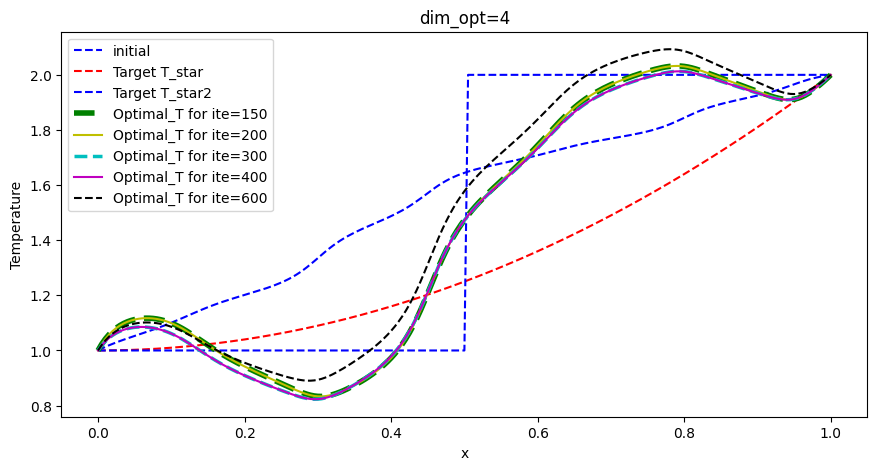

In [ ]:


plt.figure(figsize=(10.4,5))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
plt.plot(X, T_f1, 'g--', lw = 4, label=f'Optimal_T for ite={max_iter1}')
plt.plot(X, T_f2, 'y', label=f'Optimal_T for ite={max_iter2}')
plt.plot(X, T_f3, 'c--', lw= 2.5, label=f'Optimal_T for ite={max_iter3}')
plt.plot(X, T_f4, 'm', label=f'Optimal_T for ite={max_iter4}')
plt.plot(X, T_f5, 'k--', label=f'Optimal_T for ite={max_iter5}')

plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

# **Nash dim6**

## method sequentiel

In [8]:

T_star = np.ones(X.shape) + (X/l)**2
T_star2 = np.where((X >= 0) & (X <= 0.5), 1, np.where((X > 0.5) & (X <= 1), 2, None))

def J1(S) :
    T = simulator(0,S)
    r = 0
    for i in range(len(T)):
        r += 0.5*((T[i]-T_star[i])**2)*h
    return r

def J2(S) :
    T = simulator(0,S)
    r = 0
    for i in range(len(T)):
        r += 0.5*((T[i]-T_star2[i])**2)*h
    return r


def Opt1(Var, simplex, ite_max, tol):

  for i in range(ite_max):

    Var_opt = Var.copy()
    Var_opt[:dim_opt//2] = NelderMead(J1, simplex)[1][:dim_opt//2]
    if J1(Var_opt) < tol:
      break
    simplex = np.array(NelderMead(J1, simplex)[0][-1]).T


  return Var_opt, simplex

def Opt2(Var, simplex, ite_max, tol):

  for i in range(ite_max):
    Var_opt = Var.copy()
    Var_opt[dim_opt//2:] = NelderMead(J2, simplex)[1][dim_opt//2:]
    if J2(Var_opt) < tol:
      break
    simplex = np.array(NelderMead(J2, simplex)[0][-1]).T

  return Var_opt, simplex
# methode sequentiel
def Nash_NelderMead(Var, simplex, ite_max, tol):

    iter_count = 0
    Var_opt = Var.copy()

    while iter_count <= ite_max:

        Var_opt, simplex = Opt1(Var_opt, simplex, ite_max, tol)
        Var_opt, simplex = Opt2(Var_opt, simplex, ite_max, tol)

        #print(f'iteration:{iter_count}')
        #print(Var_opt)
        if np.linalg.norm(simulator(0, Var) - simulator(0, Var_opt)) < tol:
            print("Nash equivalence")
            break
        Var = Var_opt
        iter_count +=1

    return simulator(0, Var_opt)

dim_opt = 6
Var_ini = np.full(dim_opt,0)
simplex = np.column_stack((np.zeros(dim_opt), 1 * np.eye(dim_opt)))

#Simulation avec nb d'iterarion different

In [9]:

max_iter0 = 100
max_iter1 = 200
max_iter2 = 500
max_iter3 = 700
max_iter4 = 900

T_ini = simulator(0, Var_ini)
tol = 1e-1

T_final1 = Nash_NelderMead(Var_ini, simplex, max_iter0, tol)
T_final2 = Nash_NelderMead(Var_ini, simplex, max_iter1, tol)
T_final3 = Nash_NelderMead(Var_ini, simplex, max_iter2, tol)
T_final4 = Nash_NelderMead(Var_ini, simplex, max_iter3, tol)
T_final5 = Nash_NelderMead(Var_ini, simplex, max_iter4, tol)

Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence


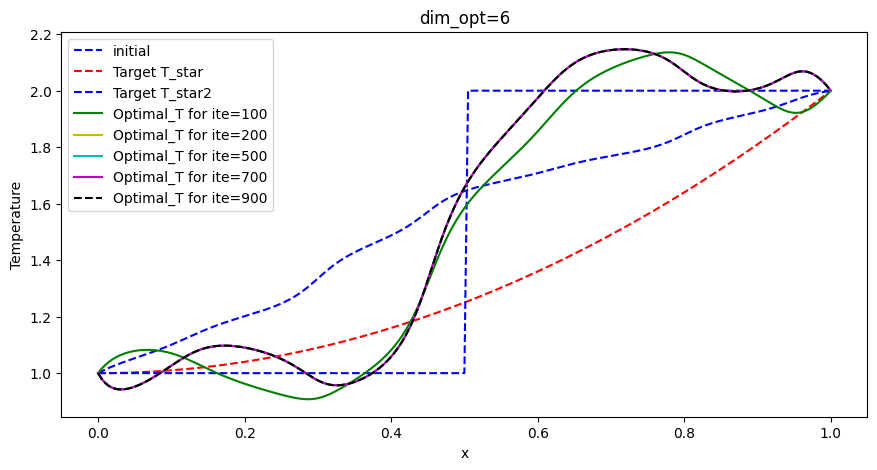

In [10]:


plt.figure(figsize=(10.4,5))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
plt.plot(X, T_final1, 'g', label=f'Optimal_T for ite={max_iter0}')
plt.plot(X, T_final2, 'y', label=f'Optimal_T for ite={max_iter1}')
plt.plot(X, T_final3, 'c', label=f'Optimal_T for ite={max_iter2}')
plt.plot(X, T_final4, 'm', label=f'Optimal_T for ite={max_iter3}')
plt.plot(X, T_final5, 'k--', label=f'Optimal_T for ite={max_iter4}')
plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

In [11]:
max_iter1 = 1
max_iter2 = 3
max_iter3 = 8
max_iter4 = 13
max_iter5 = 50

T_f1 = Nash_NelderMead(Var_ini, simplex, max_iter1, tol)
T_f2 = Nash_NelderMead(Var_ini, simplex, max_iter2, tol)
T_f3 = Nash_NelderMead(Var_ini, simplex, max_iter3, tol)
T_f4 = Nash_NelderMead(Var_ini, simplex, max_iter4, tol)
T_f5 = Nash_NelderMead(Var_ini, simplex, max_iter5, tol)


Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence


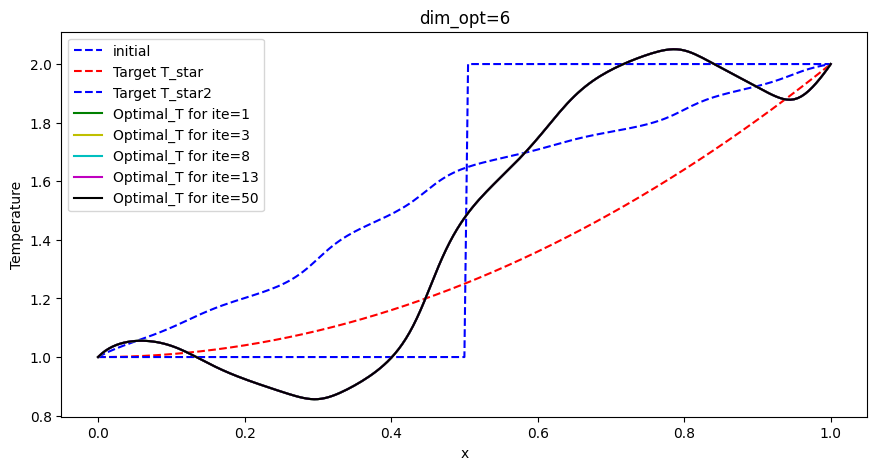

In [ ]:
plt.figure(figsize=(10.4, 5))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
plt.plot(X, T_f1, 'g', label=f'Optimal_T for ite={max_iter1}')
plt.plot(X, T_f2, 'y', label=f'Optimal_T for ite={max_iter2}')
plt.plot(X, T_f3, 'c', label=f'Optimal_T for ite={max_iter3}')
plt.plot(X, T_f4, 'm', label=f'Optimal_T for ite={max_iter4}')
plt.plot(X, T_f5, 'k', label=f'Optimal_T for ite={max_iter5}')

plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

## tol=1e-3 et simplex = np.column_stack((np.zeros(dim_opt), -3 * np.eye(dim_opt)))

iteration:0
[ -14  136 -308 -408  -18 -436]
iteration:1
[  -14   136  -308   307 -2203  1148]
iteration:2
[ -14  136 -308 -384 1527 -986]
iteration:3
[  -14   136  -308   309 -2211  1153]
iteration:4
[  -14   136  -308   309 -2211  1153]
Nash equivalence


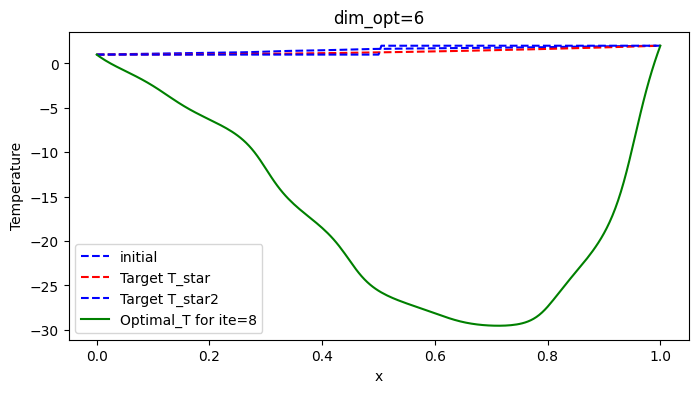

In [ ]:

max_iteri = 8
tol = 1e-3

T_finali = Nash_NelderMead(Var_ini, simplex, max_iteri, tol)
plt.figure(figsize=(8,4))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
plt.plot(X, T_finali, 'g', label=f'Optimal_T for ite={max_iteri}')
#plt.plot(X, T_finalii, 'y', label=f'Optimal_T for ite={max_iterii}')

plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

## tol=1e-1 et simplex = np.column_stack((np.zeros(dim_opt), -3 * np.eye(dim_opt)))

iteration:0
[ -14  136 -308 -385 1530 -988]
iteration:1
[ -14  136 -308 -385 1530 -988]
Nash equivalence


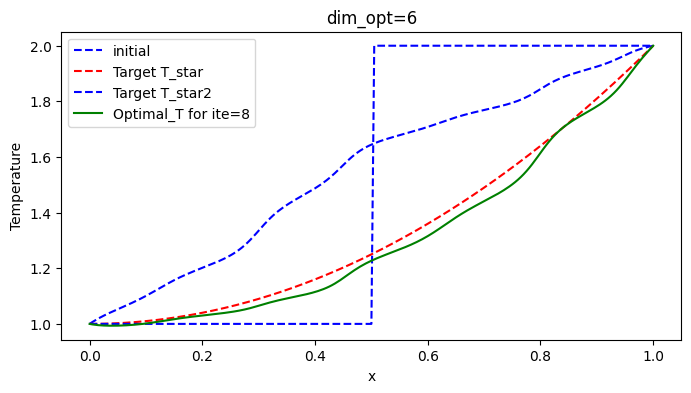

In [ ]:
max_iteri = 8
tol = 1e-1

T_finali = Nash_NelderMead(Var_ini, simplex, max_iteri, tol)
plt.figure(figsize=(8,4))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
plt.plot(X, T_finali, 'g', label=f'Optimal_T for ite={max_iteri}')
#plt.plot(X, T_finalii, 'y', label=f'Optimal_T for ite={max_iterii}')

plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

## tol=1e-1 et simplex = np.column_stack((np.zeros(dim_opt), 2 * np.eye(dim_opt)))

iteration:0
[  -3    0    0  355 -184 -426]
iteration:1
[  55 -440  546  355 -184 -426]
iteration:2
[  55 -440  546  355 -184 -426]
Nash equivalence


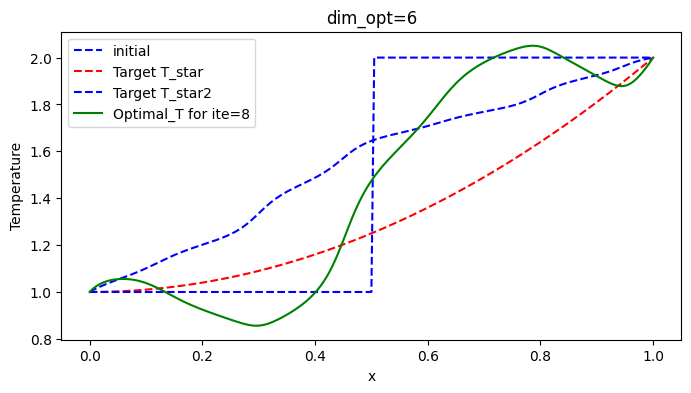

In [ ]:
max_iteri = 8
tol = 1e-1

T_finali = Nash_NelderMead(Var_ini, simplex, max_iteri, tol)
plt.figure(figsize=(8,4))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
plt.plot(X, T_finali, 'g', label=f'Optimal_T for ite={max_iteri}')
#plt.plot(X, T_finalii, 'y', label=f'Optimal_T for ite={max_iterii}')

plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

## simplex = np.column_stack((np.zeros(dim_opt), 1 * np.eye(dim_opt)))

iteration:0
[  -3    0    0  355 -184 -426]
iteration:1
[  55 -440  546  355 -184 -426]
iteration:2
[  55 -440  546  355 -184 -426]
Nash equivalence


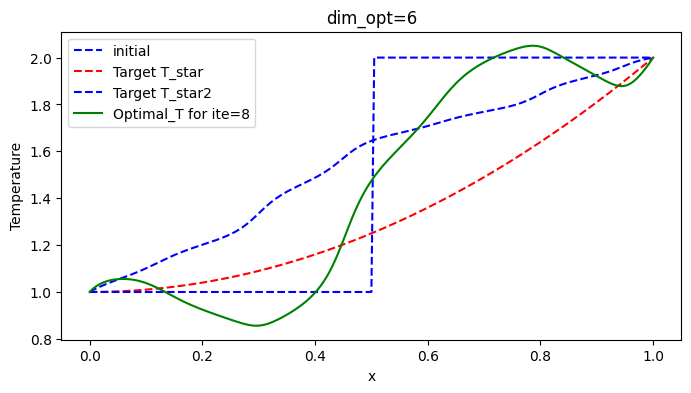

In [ ]:
max_iteri = 8
tol = 1e-1

T_finali = Nash_NelderMead(Var_ini, simplex, max_iteri, tol)
plt.figure(figsize=(8,4))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
plt.plot(X, T_finali, 'g', label=f'Optimal_T for ite={max_iteri}')
#plt.plot(X, T_finalii, 'y', label=f'Optimal_T for ite={max_iterii}')

plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

# **fonction** **cout**

In [20]:
def Nash_Var(Var, simplex, ite_max, tol):

    iter_count = 0
    Var_opt = Var.copy()

    while iter_count <= ite_max:

        Var_opt, simplex = Opt1(Var_opt, simplex, ite_max, tol)
        Var_opt, simplex = Opt2(Var_opt, simplex, ite_max, tol)

        #print(f'iteration:{iter_count}')
        #print(Var_opt)
        if np.linalg.norm(simulator(0, Var) - simulator(0, Var_opt)) < tol:
            print("Nash equivalence")
            break
        Var = Var_opt
        iter_count +=1

    return Var_opt

dim_opt = 6
Var_ini = np.full(dim_opt,0)
simplex = np.column_stack((np.zeros(dim_opt), 1 * np.eye(dim_opt)))

ite = np.linspace(5, 211, 15, dtype=int)
var = []
cout1 = []
cout2 = []

for i in range(len(ite)):
    var_result = Nash_Var(Var_ini, simplex, ite[i], tol)
    var.append(var_result)
    cout1.append(J1(var_result))
    cout2.append(J2(var_result))


Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence
Nash equivalence


**Affichage**

fonction de cout1=[0.0351318226615985, 0.0351318226615985, 0.0351318226615985, 0.0351318226615985, 0.0351318226615985, 0.0010595647636131662, 0.050363506100924695, 0.04426551555539904, 0.050363506100924695, 0.0004034253571222743, 0.06092556714971403, 0.06092556714971403, 0.06092556714971403, 0.06092556714971403, 0.06092556714971403]
fonction de cout2=[0.014308920210697587, 0.014308920210697587, 0.014308920210697587, 0.014308920210697587, 0.014308920210697587, 0.04907547683410619, 0.012914519047925326, 0.01272372736346222, 0.012914519047925326, 0.05355873357204287, 0.01197717141659591, 0.01197717141659591, 0.01197717141659591, 0.01197717141659591, 0.01197717141659591]
Var optimisee: [  55 -440  546  355 -184 -426]


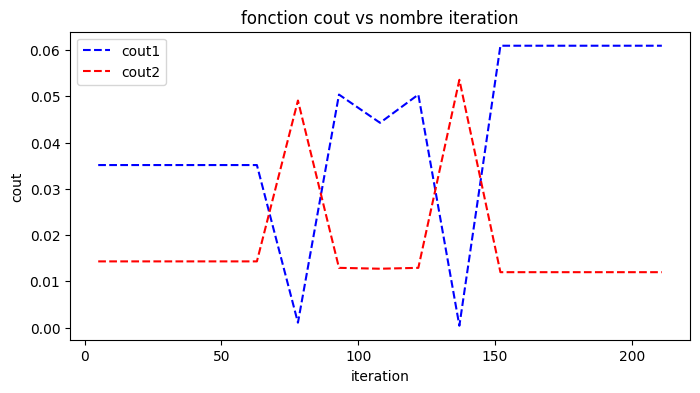

In [22]:
print(f'fonction de cout1={cout1}')
print(f'fonction de cout2={cout2}')
print(f'Var optimisee: {var}')

plt.figure(figsize=(8,4))
plt.plot(ite, cout1, 'b--', label='cout1')
plt.plot(ite, cout2, 'r--', label='cout2')
plt.xlabel('iteration')
plt.ylabel('cout')
plt.title('fonction cout vs nombre iteration')
plt.legend()
plt.show()

#

# **Nouvelle parametrage**

In [ ]:

T_star = np.ones(X.shape) + (X/l)**2
T_star2 = np.where((X >= 0) & (X <= 0.5), 1, np.where((X > 0.5) & (X <= 1), 2, None))

def J1(S) :
    T = simulator(0,S)
    r = 0
    for i in range(len(T)):
        r += 0.5*((T[i]-T_star[i])**2)*h
    return r

def J2(S) :
    T = simulator(0,S)
    r = 0
    for i in range(len(T)):
        r += 0.5*((T[i]-T_star2[i])**2)*h
    return r


def Opt1(Var, simplex, ite_max, tol):

  for i in range(ite_max):

    Var_opt = Var.copy()

    Var_opt[dim_opt//6: 6*dim_opt//10] = NelderMead(J1, simplex)[1][dim_opt//6: 6*dim_opt//10]

    if J1(Var_opt) < tol:
      break
    simplex = np.array(NelderMead(J1, simplex)[0][-1]).T


  return Var_opt, simplex

def Opt2(Var, simplex, ite_max, tol):

  for i in range(ite_max):

    Var_opt = Var.copy()

    Var_opt[:dim_opt//6] = NelderMead(J2, simplex)[1][:dim_opt//6]
    Var_opt[6*dim_opt//10: ] = NelderMead(J2, simplex)[1][6*dim_opt//10: ]

    if J2(Var_opt) < tol:
      break
    simplex = np.array(NelderMead(J2, simplex)[0][-1]).T

  return Var_opt, simplex

def Nash_NelderMead(Var, simplex, ite_max, tol):

    iter_count = 0
    Var_opt = Var.copy()

    while iter_count <= ite_max:

        Var_opt, simplex = Opt1(Var_opt, simplex, ite_max, tol)
        Var_opt, simplex = Opt2(Var_opt, simplex, ite_max, tol)

        #print(f'iteration:{iter_count}')
        #print(Var_opt)
        if np.linalg.norm(simulator(0, Var) - simulator(0, Var_opt)) < tol:
            print("Nash equivalence")
            break
        Var = Var_opt
        iter_count +=1

    return simulator(0, Var_opt)

dim_opt = 6
Var_ini = np.full(dim_opt,0)


Calcul

In [ ]:

simplex = np.column_stack((np.zeros(dim_opt), 0.8 * np.eye(dim_opt)))
#max_iter0 = 100
#max_iter1 = 200
#max_iter2 = 500
#max_iter3 = 700
max_iter4 = 200

T_ini = simulator(0, Var_ini)
tol = 1e-1

#T_final1 = Nash_NelderMead(Var_ini, simplex, max_iter0, tol)
#T_final2 = Nash_NelderMead(Var_ini, simplex, max_iter1, tol)
#T_final3 = Nash_NelderMead(Var_ini, simplex, max_iter2, tol)
#T_final4 = Nash_NelderMead(Var_ini, simplex, max_iter3, tol)
T_final5 = Nash_NelderMead(Var_ini, simplex, max_iter4, tol)

iteration:0
[  66  -11    4 -126 -151 -282]
iteration:1
[  66 -570  980 -126 -151 -282]
iteration:2
[  66 -570  980 -126 -151 -282]
Nash equivalence


graphe

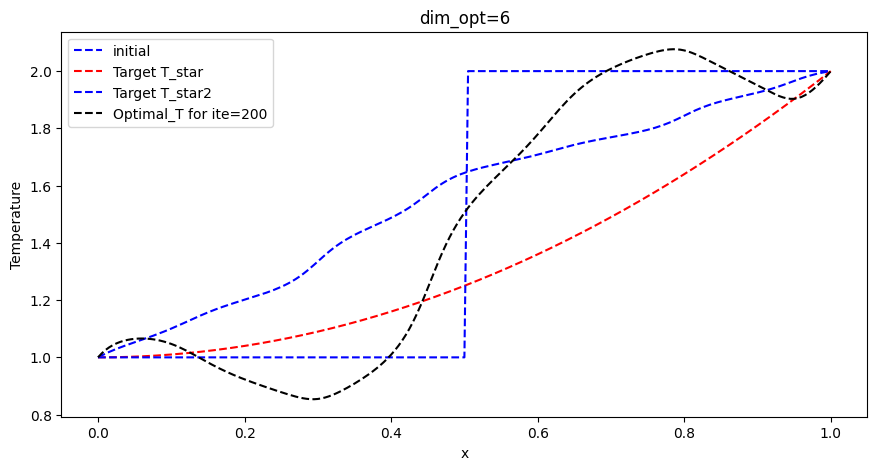

In [ ]:

plt.figure(figsize=(10.4,5))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
#plt.plot(X, T_final1, 'g', label=f'Optimal_T for ite={max_iter0}')
#plt.plot(X, T_final2, 'y', label=f'Optimal_T for ite={max_iter1}')
#plt.plot(X, T_final3, 'c', label=f'Optimal_T for ite={max_iter2}')
#plt.plot(X, T_final4, 'm', label=f'Optimal_T for ite={max_iter3}')
plt.plot(X, T_final5, 'k--', label=f'Optimal_T for ite={max_iter4}')
plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

# methode parallele

Nash equivalence


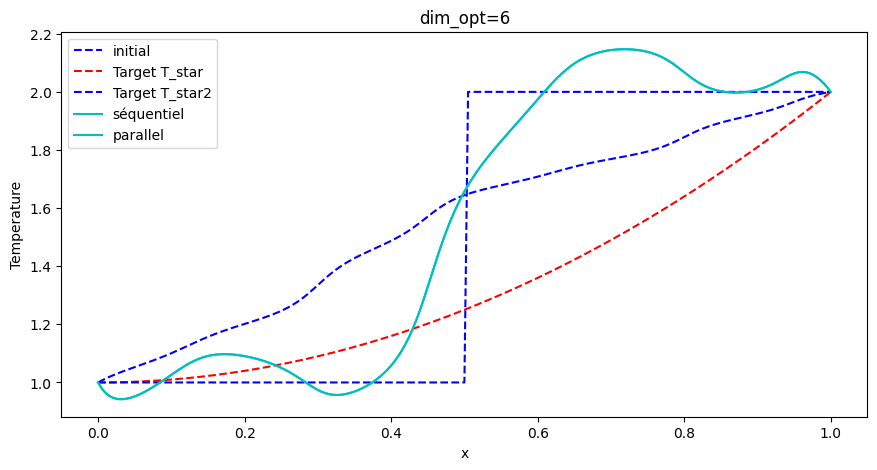

In [17]:
T_star = np.ones(X.shape) + (X/l)**2
T_star2 = np.where((X >= 0) & (X <= 0.5), 1, np.where((X > 0.5) & (X <= 1), 2, None))

def J1(S) :
    T = simulator(0,S)
    r = 0
    for i in range(len(T)):
        r += 0.5*((T[i]-T_star[i])**2)*h
    return r

def J2(S) :
    T = simulator(0,S)
    r = 0
    for i in range(len(T)):
        r += 0.5*((T[i]-T_star2[i])**2)*h
    return r


def Opt1(Var, simplex, ite_max, tol):

  for i in range(ite_max):

    Var_opt = Var.copy()

    Var_opt[dim_opt//4: 8*dim_opt//10] = NelderMead(J1, simplex)[1][dim_opt//4: 8*dim_opt//10]
    #Var_opt[8*dim_opt//10 : ] = NelderMead(J1, simplex)[1][8*dim_opt//10 :  ]

    if J1(Var_opt) < tol:
      break
    simplex = np.array(NelderMead(J1, simplex)[0][-1]).T


  return Var_opt, simplex

def Opt2(Var, simplex, ite_max, tol):

  for i in range(ite_max):

    Var_opt = Var.copy()

    Var_opt[:dim_opt//4] = NelderMead(J2, simplex)[1][:dim_opt//4]
    Var_opt[8*dim_opt//10 :] = NelderMead(J2, simplex)[1][8*dim_opt//10 :]


    if J2(Var_opt) < tol:
      break
    simplex = np.array(NelderMead(J2, simplex)[0][-1]).T

  return Var_opt, simplex
# methode parallele
def Nash_NelderMead(Var, simplex, ite_max, tol):

    iter_count = 0
    Var_opt = Var.copy()

    simplex1 = simplex.copy()
    simplex2 = simplex.copy()

    while iter_count <= ite_max:

        Var_opt, simplex1 = Opt1(Var_opt, simplex2, ite_max, tol)
        Var_opt, simplex2 = Opt2(Var_opt, simplex1, ite_max, tol)

        if np.linalg.norm(simulator(0, Var) - simulator(0, Var_opt)) < tol:
            print("Nash equivalence")
            break
        Var = Var_opt
        iter_count +=1

    return simulator(0, Var_opt)

dim_opt = 6
Var_ini = np.full(dim_opt,0)
simplex = np.column_stack((np.zeros(dim_opt), 1 * np.eye(dim_opt)))

#max_iter0 = 100
#max_iter1 = 200
#max_iter2 = 500
#max_iter3 = 700
max_iter4 = 200

T_ini = simulator(0, Var_ini)
tol = 1e-1

#T_final1 = Nash_NelderMead(Var_ini, simplex, max_iter0, tol)
#T_final2 = Nash_NelderMead(Var_ini, simplex, max_iter1, tol)
#T_final3 = Nash_NelderMead(Var_ini, simplex, max_iter2, tol)
#T_final4 = Nash_NelderMead(Var_ini, simplex, max_iter3, tol)
T_final5 = Nash_NelderMead(Var_ini, simplex, max_iter4, tol)


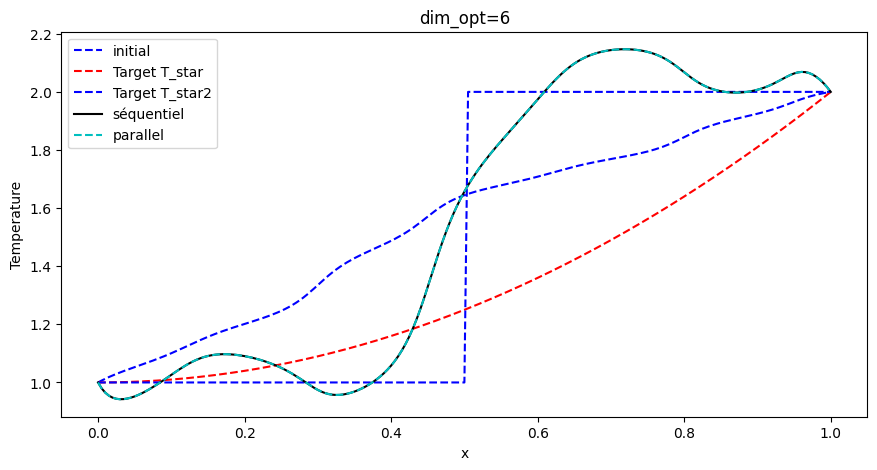

In [19]:
plt.figure(figsize=(10.4,5))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
#plt.plot(X, T_final1, 'g', label=f'Optimal_T for ite={max_iter0}')
plt.plot(X, T_final2, 'k', label='séquentiel')
#plt.plot(X, T_final3, 'c', label=f'Optimal_T for ite={max_iter2}')
#plt.plot(X, T_final4, 'm', label=f'Optimal_T for ite={max_iter3}')
plt.plot(X, T_final5, 'c--', label='parallel')
plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()

#test


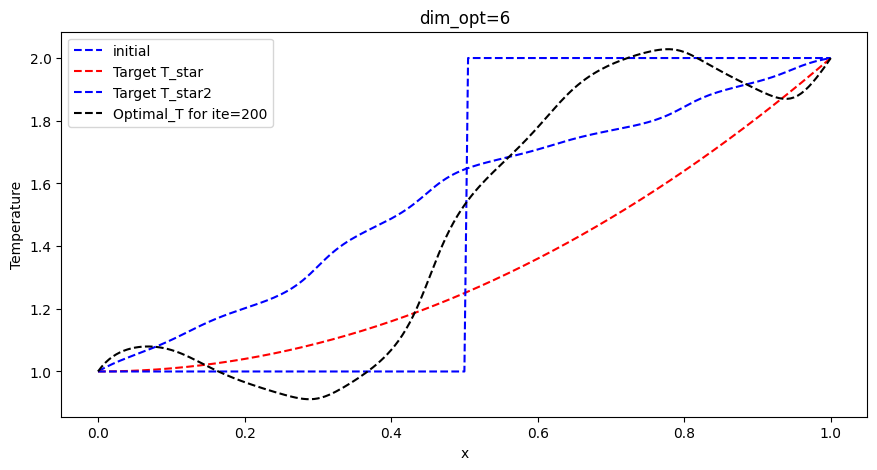

In [46]:
var = np.array([66, -573, 1050, -285,  -72, -270])
#
t = simulator(0,var)


plt.figure(figsize=(10.4,5))
plt.plot(X, T_ini, 'b--', label='initial')
plt.plot(X, T_star, 'r--', label='Target T_star')
plt.plot(X, T_star2, 'b--', label='Target T_star2')
#plt.plot(X, T_final1, 'g', label=f'Optimal_T for ite={max_iter0}')
#plt.plot(X, T_final2, 'y', label=f'Optimal_T for ite={max_iter1}')
#plt.plot(X, T_final3, 'c', label=f'Optimal_T for ite={max_iter2}')
#plt.plot(X, T_final4, 'm', label=f'Optimal_T for ite={max_iter3}')

plt.plot(X, t, 'k--', label=f'Optimal_T for ite={max_iter4}')

plt.xlabel('x')
plt.ylabel('Temperature')
plt.title(f'dim_opt={dim_opt}')
plt.legend()
plt.show()